In [80]:
#imports 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.wrappers.scikit_learn import KerasClassifier
%matplotlib inline

<b>Task 1</b>

1. Load the MNSIT data set and split into training and test sets.

(60000, 28, 28)

(60000,)

(10000, 28, 28)

(10000,)

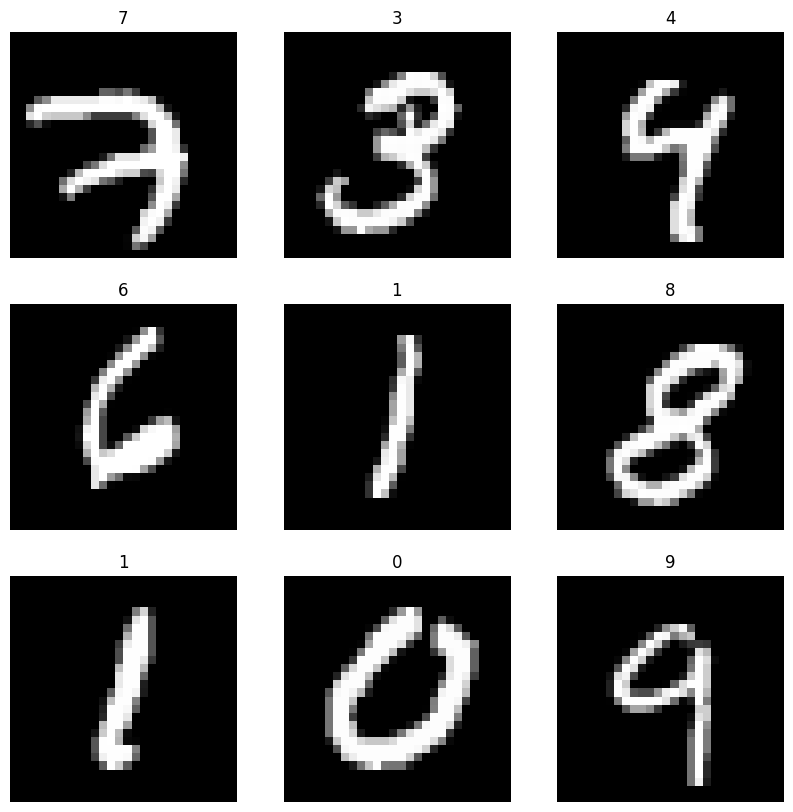

In [81]:
mnsit = keras.datasets.mnist
(X_train_full, y_train_full), (X_test, y_test) = mnsit.load_data()

display(X_train_full.shape)

display(y_train_full.shape)

display(X_test.shape)
display(y_test.shape)

#splitting the data into training and validation sets and scaling the pixel intensities down to the 0-1 range. 
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]


#displaying the 9 images from the training set
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(y_train[i])
    plt.axis('off')

#one hot encode the target variables to make them easier to work with
y_train = keras.utils.to_categorical(y_train, 10)
y_valid = keras.utils.to_categorical(y_valid, 10)
y_test = keras.utils.to_categorical(y_test, 10)

#Dataset contains 28x28 pixel images, and each feature simply represents one pixel's intensity, from 0 (white) to 255 (black). The possible values are 0-9, so there are 10 classes. 

In [82]:
# Create a function to free the memory if necessary 
def free_memory(): 
    keras.backend.clear_session()


<b>Task 2</b>

2. Build a CNN with at least one convolutional layer and 2 or more hidden layers and a dense output layer for 10 classes.

In [83]:
def create_original_model(activation, optimizer, learning_rate):
    # Create a Sequential model
    model = keras.models.Sequential()
    # Add a convolutional layer with 32 filters, each with a 3x3 kernel size. Add padding to preserve the dimensions. 
    model.add(Conv2D(32, (3, 3), activation="relu", padding = 'same', input_shape=(28, 28, 1)))
    # Add a max pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Add a flattening layer to flatten the data for dense layers
    model.add(Flatten())
    # Add a dense hidden layer with 128 neurons 
    model.add(Dense(128, activation=activation))
    # Add another dense hidden layer with 64 neurons 
    model.add(Dense(64, activation=activation))
    # Add a dense output layer with 10 neurons (for 10 classes) and softmax activation
    model.add(Dense(10, activation="softmax"))
    # Compile the model with the specified optimizer, loss function, and metric
    optimizer = keras.optimizers.get(optimizer)
    optimizer.learning_rate = learning_rate
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model


<b>Task 3</b>

3. Train your CNN on the MNIST training set (extracted in step 1).

Model: "sequential_159"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_157 (Conv2D)         (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_157 (MaxPooli  (None, 14, 14, 32)       0         
 ng2D)                                                           
                                                                 
 flatten_159 (Flatten)       (None, 6272)              0         
                                                                 
 dense_501 (Dense)           (None, 128)               802944    
                                                                 
 dense_502 (Dense)           (None, 64)                8256      
                                                                 
 dense_503 (Dense)           (None, 10)                650       
                                                    

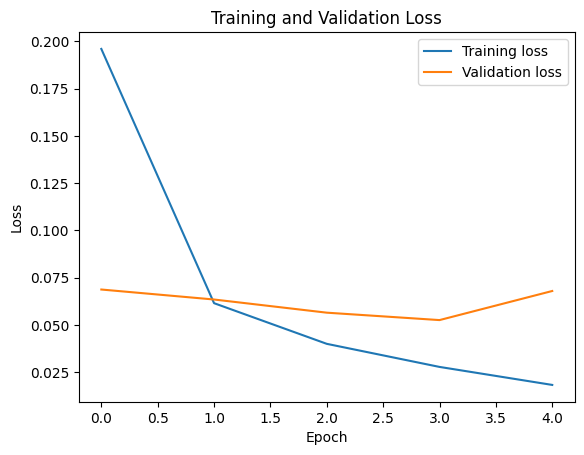

In [96]:
original_model = create_original_model("relu","adam",0.001)
print(original_model.summary())
keras.utils.plot_model(original_model, show_shapes=True)

#train the model
X_train = X_train.reshape((55000, 28, 28, 1))
X_valid = X_valid.reshape((5000, 28, 28, 1))
X_test = X_test.reshape((10000, 28, 28, 1))

history = original_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_valid, y_valid))

# Plot the training history
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()



<b>Task 4</b>

4. Evaluate your trained model using the test data set. What is the accuracy of your model?

  1/313 [..............................] - ETA: 5s - loss: 48.9660 - accuracy: 0.9375

313/313 [==============================] - 0s 1ms/step - loss: 31.8033 - accuracy: 0.9684
Test accuracy: 0.9684000015258789
Test loss: 31.803306579589844
313/313 [==============================] - 0s 1ms/step


Text(33.22222222222222, 0.5, 'True label')

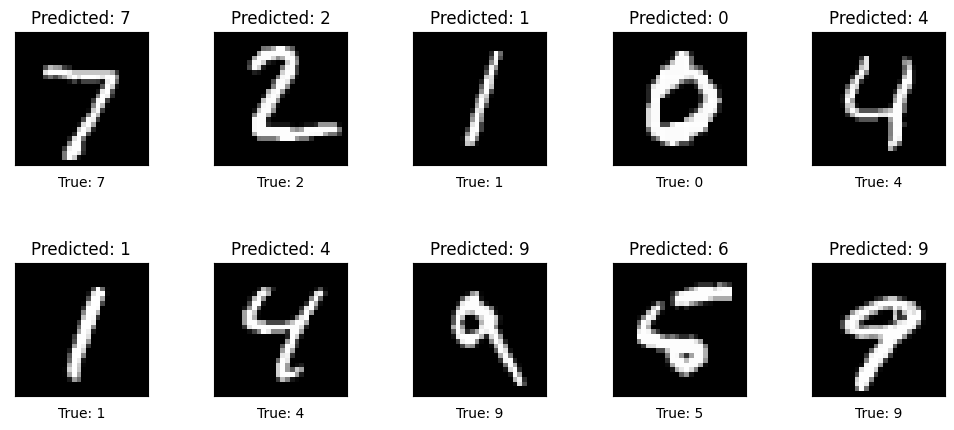

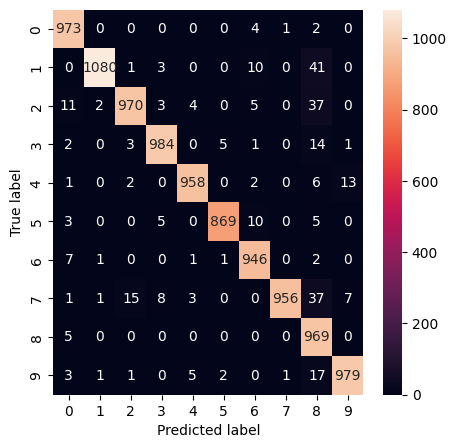

In [95]:
#evaluate the model
test_loss, test_accuracy = original_model.evaluate(X_test, y_test)
print('Test accuracy:', test_accuracy)
print('Test loss:', test_loss)
# Make predictions
predictions = original_model.predict(X_test)

#Plot the first 10 test images, their predicted label, and the true label
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i].reshape(28, 28), cmap='gray')
    ax.set_title(f'Predicted: {np.argmax(predictions[i])}')
    ax.set_xlabel(f'True: {np.argmax(y_test[i])}')
    ax.set_xticks([])
    ax.set_yticks([])

# Plot confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')


<b>Task 5</b>

5. Do the following experiments to improve accuracy:

    - increase the size and depth of the inner layers, what is the effect on the model accuracy?

    - experiment with different activation functions in the inner layers (relu, sigmoid, softmask, etc), see the list of keras activation functions at https://keras.io/api/layers/activations/

    - what is the effect of using different activation functions (relu, sigmoid, softmask)? how about combining the activation function choice with different network size and depth?

    - experiment with various optimizers (at least 2) (https://keras.io/api/optimizers/) and learning rate. What is the effect on the resulting model accuracy?

    - with all the above variations, experiment with various batch sizes and epochs for training (see https://keras.io/api/models/model_training_apis/)

    - what happens if we don't use any CNN layer? (considering the model in https://www.tensorflow.org/datasets/keras_example).

In [86]:
def create_model(activation, hidden_layer_sizes, optimizer):
     model = keras.models.Sequential()
     model.add(Conv2D(32, (3, 3), activation="relu", padding = 'same', input_shape=(28, 28, 1)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Flatten())
     for units in hidden_layer_sizes:
        model.add(Dense(units, activation=activation))
     model.add(Dense(10, activation='softmax'))
     model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
     return model

hidden_layer_sizes = [
        {'units': [256, 128]},
        {'units': [256, 128, 64]}
    ]

# With all the above variations, experiment with various batch sizes and epochs for training
batch_sizes = [32, 64]
epochs = [2, 5, 10]

#Increase the size and depth of the inner layers
for batch_size in batch_sizes:
    for epoch in epochs:
        for layer_sizes in hidden_layer_sizes:
            print("Model with inner layer sizes: " ,layer_sizes["units"], " batch size: ", batch_size, " epochs: ", epoch)
            model = create_model(activation='relu', hidden_layer_sizes=layer_sizes["units"], optimizer='adam')
            model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_data=(X_valid, y_valid))
            test_loss, test_accuracy = model.evaluate(X_test, y_test)
            print('Test accuracy:', test_accuracy) 
            print('Test loss:', test_loss)


Model with inner layer sizes:  [256, 128]  batch size:  32  epochs:  2
Epoch 1/2
1719/1719 [==============================] - 22s 12ms/step - loss: 0.1459 - accuracy: 0.9545 - val_loss: 0.0610 - val_accuracy: 0.9808
Epoch 2/2
313/313 [==============================] - 1s 2ms/step - loss: 43.3172 - accuracy: 0.9470
Test accuracy: 0.9470000267028809
Test loss: 43.31718826293945
Model with inner layer sizes:  [256, 128, 64]  batch size:  32  epochs:  2
Epoch 1/2
1719/1719 [==============================] - 21s 12ms/step - loss: 0.1525 - accuracy: 0.9537 - val_loss: 0.0815 - val_accuracy: 0.9750
Epoch 2/2
313/313 [==============================] - 1s 2ms/step - loss: 23.4477 - accuracy: 0.9675
Test accuracy: 0.9674999713897705
Test loss: 23.447702407836914
Model with inner layer sizes:  [256, 128]  batch size:  32  epochs:  5
Epoch 1/5
1719/1719 [==============================] - 20s 11ms/step - loss: 0.1424 - accuracy: 0.9563 - val_loss: 0.0605 - val_accuracy: 0.9822
Epoch 2/5
1719/1719 [

In [89]:
#Experiment the orinal model with different activation functions
activations = ['softmax', 'sigmoid','tanh',]

for epoch in epochs:
    for batch_size in batch_sizes:
        for activation in activations:
            print("Original model with activation: " ,activation, " batch size: ", batch_size, " epochs: ", epoch)
            model = create_original_model(activation, 'adam', 0.001)
            model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_data=(X_valid, y_valid))
            test_loss, test_accuracy = model.evaluate(X_test, y_test)
            print('Test accuracy:', test_accuracy)
            print('Test loss:', test_loss)

#Experiment the incresed size and depth of the inner layers with different activation functions
for epoch in epochs:
    for batch_size in batch_sizes:
        for layer_sizes in hidden_layer_sizes:
            for activation in activations:
                print("Model with inner layer sizes: " ,layer_sizes["units"], " activation: ", activation, " batch size: ", batch_size, " epochs: ", epoch)
                model = create_model(activation=activation, hidden_layer_sizes=layer_sizes["units"], optimizer='adam')
                model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_data=(X_valid, y_valid))
                test_loss, test_accuracy = model.evaluate(X_test, y_test)
                print('Test accuracy:', test_accuracy) 
                print('Test loss:', test_loss)

Original model with activation:  softmax  batch size:  32  epochs:  2
Epoch 1/2
1719/1719 [==============================] - 12s 7ms/step - loss: 1.7279 - accuracy: 0.5737 - val_loss: 0.9351 - val_accuracy: 0.6814
Epoch 2/2
313/313 [==============================] - 1s 1ms/step - loss: 0.7840 - accuracy: 0.6620
Test accuracy: 0.6620000004768372
Test loss: 0.7839609384536743
Original model with activation:  sigmoid  batch size:  32  epochs:  2
Epoch 1/2
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2860 - accuracy: 0.9311 - val_loss: 0.0843 - val_accuracy: 0.9764
Epoch 2/2
313/313 [==============================] - 1s 2ms/step - loss: 0.1697 - accuracy: 0.9459
Test accuracy: 0.945900022983551
Test loss: 0.16974376142024994
Original model with activation:  tanh  batch size:  32  epochs:  2
Epoch 1/2
1719/1719 [==============================] - 14s 8ms/step - loss: 0.1416 - accuracy: 0.9590 - val_loss: 0.0707 - val_accuracy: 0.9794
Epoch 2/2
313/313 [================

In [92]:
#Experiment with different optimizers and learning rates 

optimizers =  ['adam', 'sgd']
learning_rates = [0.001, 0.01, 0.1]

for epoch in epochs:
    for batch_size in batch_sizes:
        for optimizer in optimizers:
            for learning_rate in learning_rates:
                print("Model with optimizer: " , optimizer, "learning rate: ", learning_rate, " batch size: ", batch_size, " epochs: ", epoch)
                model = create_original_model('relu', optimizer,learning_rate)
                model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_data=(X_valid, y_valid))
                test_loss, test_accuracy = model.evaluate(X_test, y_test)
                print('Test accuracy:', test_accuracy)
                print('Test loss:', test_loss)
            

    

Model with optimizer:  adam learning rate:  0.001  batch size:  32  epochs:  2
Epoch 1/2
1719/1719 [==============================] - 10s 5ms/step - loss: 0.1655 - accuracy: 0.9491 - val_loss: 0.0711 - val_accuracy: 0.9784
Epoch 2/2
313/313 [==============================] - 1s 1ms/step - loss: 31.9789 - accuracy: 0.9559
Test accuracy: 0.9559000134468079
Test loss: 31.978872299194336
Model with optimizer:  adam learning rate:  0.01  batch size:  32  epochs:  2
Epoch 1/2
1719/1719 [==============================] - 13s 7ms/step - loss: 0.1629 - accuracy: 0.9517 - val_loss: 0.0861 - val_accuracy: 0.9768
Epoch 2/2
313/313 [==============================] - 0s 1ms/step - loss: 46.7357 - accuracy: 0.9631
Test accuracy: 0.963100016117096
Test loss: 46.735721588134766
Model with optimizer:  adam learning rate:  0.1  batch size:  32  epochs:  2
Epoch 1/2
1719/1719 [==============================] - 14s 8ms/step - loss: 2.4059 - accuracy: 0.1042 - val_loss: 2.3305 - val_accuracy: 0.1126
Epoch 2

Epoch 1/5
860/860 [==============================] - 2s 1ms/step - loss: 0.2927 - accuracy: 0.9152 - val_loss: 0.1388 - val_accuracy: 0.9620
Epoch 2/5
860/860 [==============================] - 1s 1ms/step - loss: 0.1224 - accuracy: 0.9638 - val_loss: 0.0977 - val_accuracy: 0.9714
Epoch 3/5
860/860 [==============================] - 1s 1ms/step - loss: 0.0857 - accuracy: 0.9735 - val_loss: 0.0862 - val_accuracy: 0.9746
Epoch 4/5
860/860 [==============================] - 1s 1ms/step - loss: 0.0632 - accuracy: 0.9809 - val_loss: 0.0779 - val_accuracy: 0.9790
Epoch 5/5
313/313 [==============================] - 0s 731us/step - loss: 15.6455 - accuracy: 0.9717
Test accuracy: 0.9717000126838684
Test loss: 15.645517349243164
313/313 [==============================] - 0s 649us/step


Text(33.22222222222222, 0.5, 'True label')

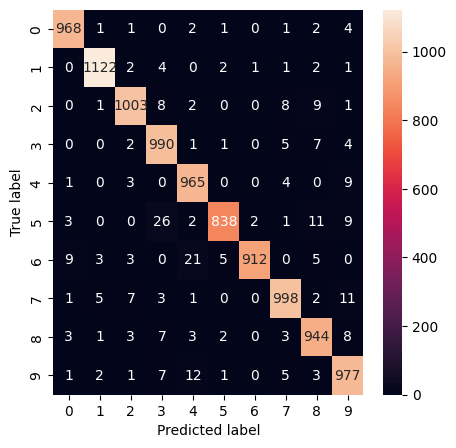

In [99]:
#what happens if we don't use any CNN layer?
model = keras.models.Sequential()
model.add(Flatten(input_shape=(28, 28)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_valid, y_valid))
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print('Test accuracy:', test_accuracy)
print('Test loss:', test_loss)

#Confusion matrix 
predictions = model.predict(X_test)
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')

